In [129]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import pandas as pd
import numpy as np
import json
from datetime import date, datetime
import logging
from elastic_util import *
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
logger = logging.getLogger('psychosis_risk_cal')
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s : %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# 1. Read test data

In [130]:
test_df = pd.read_excel('data/test_data.xlsx')

In [131]:
test_df.shape

(120, 55)

# 1.1 Original calculation is only for patients whose ages are large than 16

In [132]:
test_df['index_diagnosis_date'] = pd.to_datetime(test_df['index_diagnosis_date'], errors='coerce').dt.date

In [133]:
min_date = min(test_df['index_diagnosis_date'])

In [134]:
max_date = max(test_df['index_diagnosis_date'])

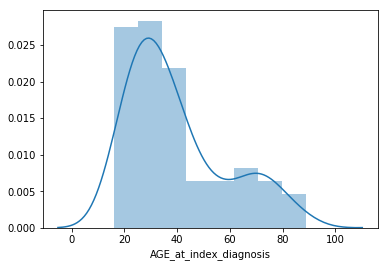

In [135]:
sns.distplot(test_df['AGE_at_index_diagnosis'])
plt.show()

In [136]:
min(test_df['AGE_at_index_diagnosis'])

16

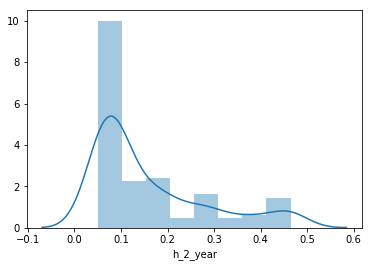

In [137]:
sns.distplot(test_df['h_2_year'])
plt.show()

# 2. Read data from Cogstack

In [138]:
logger.info('Connect to host.....')
client = Elasticsearch(['http://10.16.31.65:9200/'], request_timeout=600)
doc_type='doc'
index = 'psychosis_risk'
s = Search(using=client, index=index, doc_type=doc_type).filter('range', h_2_year={'gte': 0.05})
logger.info('Loaded %s documents' %s.count())
df = pd.DataFrame((d.to_dict() for d in s.scan()))
logger.info('Documents shape: %s %s' %(df.shape))

logger.info('Change data types')
#     df['first_primary_diagnosis_date'] = pd.to_datetime(df['first_primary_diagnosis_date'])
#     df['patient_date_of_birth'] = pd.to_datetime(df['patient_date_of_birth'])
#     df['first_primary_diagnosis_recorded_date'] = pd.to_datetime(df['first_primary_diagnosis_recorded_date'])
#     print(df.dtypes)
#     df['patient_id'] = df['patient_id'].astype(int)
#     df['referral_id'] = df['referral_id'].astype(int)
logger.info('Documents shape after changing data types: %s %s' %(df.shape))

2019-07-09 17:13:30,469 psychosis_risk_cal INFO     : Connect to host.....
2019-07-09 17:13:30,478 psychosis_risk_cal INFO     : Loaded 4989 documents
2019-07-09 17:13:31,319 psychosis_risk_cal INFO     : Documents shape: 4989 70
2019-07-09 17:13:31,321 psychosis_risk_cal INFO     : Change data types
2019-07-09 17:13:31,322 psychosis_risk_cal INFO     : Documents shape after changing data types: 4989 70


In [139]:
df.shape

(4989, 70)

# 3. Records missed in Cogstack

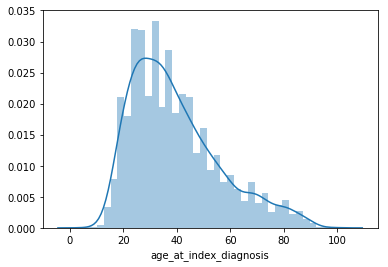

In [140]:
sns.distplot(df['age_at_index_diagnosis'])
plt.show()

In [141]:
set(test_df['Other_ID1']) - set(df['patient_other_id1'])

{'56-08-72', '59-64-19', '61-27-69'}

## There are 3 records are missed in Cogstack, 


## Reason for the other 2 missed records (i.e., patients with "Other_ID1" of '59-64-19' and '61-27-69'): 

## Original calculation did not exclude invalid diagnosis, see the "index_primary_diagnosis" filed in the Excel file. The "index_primary_diagnosis" of these patients in the Excel file are "F31.3 - Bipolar affect disorder cur epi mild or moderate depression" and "F30.1 - Mania without psychotic symptoms", the same as the Primary_Diag of these patients' invalid diagnoses.

## Below is the diagnoses of these two patients from ePJS. The first Primary_Diag of these two patients are invalid, so they are excluded in Cogstack-based calculations.

## Patient "56-08-72" moved from SLaM to NHS CAMDEN CCG on May 23rd 2019 after diagnoised in SLaM on July 11th 2018

|Patient_ID|Other_ID1|
|----------|---------|
|471259|59-64-19|


|ICD10_ID|Patient_ID|Diagnosis_Date|Created_Date|dnum|Primary_Diag|Invalid_Flag_ID|Invalid_Date|Invalid_Reason|
|--------|----------|--------------|------------|----|------------|---------------|------------|--------------|
|833975|471259|2018-03-19|2018-03-19|1|F31.3 - Bipolar affect disorder cur epi mild or moderate depression|1|2018-04-10 00:00:00|Wrong diagnosis entered erroneously |
|837500|471259|2018-04-10|2018-04-10|2|F32.1 - Moderate depressive episode|0|||
|862940|471259|2018-08-28|2018-08-28|3|F33.4 - Recurrent depressive disorder, currently in remission|0|||



|Patient_ID|Other_ID1|
|----------|---------|
|487618|61-27-69|


|ICD10_ID|Patient_ID|Diagnosis_Date|Created_Date|dnum|Primary_Diag|Invalid_Flag_ID|Invalid_Date|Invalid_Reason|
|--------|----------|--------------|------------|----|------------|---------------|------------|--------------|
|875441|487618|2018-11-09|2018-11-09|1|F30.1 - Mania without psychotic symptoms|1|2018-11-09 00:00:00||
|875442|487618|2018-11-09|2018-11-09|2|F30.2 - Mania with psychotic symptoms|0|||
|882163|487618|2018-12-12|2018-12-12|3|F30.2 - Mania with psychotic symptoms|0|||
|887016|487618|2019-01-12|2019-01-12|4|F30.2 - Mania with psychotic symptoms|0|||
|888452|487618|2019-01-21|2019-01-21|5|F30.2 - Mania with psychotic symptoms|0|||
|889448|487618|2019-01-25|2019-01-25|6|F30.2 - Mania with psychotic symptoms|0|||
|890244|487618|2019-01-30|2019-01-30|7|F30.2 - Mania with psychotic symptoms|0|||
|890914|487618|2019-01-30|2019-02-02|8|F30.2 - Mania with psychotic symptoms|0|||



# 4. Check differences of risk scores

In [142]:
common_ids = set(test_df['Other_ID1']).intersection(set(df['patient_other_id1']))

In [143]:
len(common_ids)

117

In [144]:
orig_fields = ['Gender_co_ef', 'Age_co_ef', 'diagnosis_group_co_ef', 'Eth_co_ef', 'GenderAge']
cog_fields = ['gender_coeff', 'age_coeff', 'diagnosis_group_coeff', 'eth_coeff', 'gender_age_coeff']
flen = len(orig_fields)

## 4.1 Check different of PI

In [145]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['PI'].values[0]
    cog = df[df['patient_other_id1'] == id]['PI'].values[0]
    if abs(orig - cog) > 0.00001:
        mis_count += 1
        print(str(id) + ' is different on PI values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.00001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

56-85-16 is different on PI values: 0.5606118   0.1525082
	eth_coeff is different:  0.4081036   0.0
49-70-14 is different on PI values: 1.5722854   1.5308083000000001
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
2


|patient_id|patient_updated_dttm|patient_name|patient_other_id1|patient_date_of_birth|patient_demography_gender|patient_demography_ethnicity|
|----------|--------------------|------------|-----------------|---------------------|-------------------------|----------------------------|
|443341|2019-01-02 11:44:32|Ms Alisha Rouse|56-85-16|1990-11-21|Female|British (A)|


|patient_id|patient_updated_dttm|patient_name|patient_other_id1|patient_date_of_birth|patient_demography_gender|patient_demography_ethnicity|
|----------|--------------------|------------|-----------------|---------------------|-------------------------|----------------------------|
|371803|2018-12-04 11:19:35|Mr Adir Ferriera Da Silva|49-70-14|1968-08-30|Male|Portuguese (C4)|


## The above two patients have updates about their demographic information on 2019-01-02 and 2018-12-04, the dates after the dates of original risk calculations, i.e., 29/11/2018 and 28/11/2018 respectively.

## 4.1 Check different of h_2_year

In [146]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['h_2_year'].values[0]
    cog = df[df['patient_other_id1'] == id]['h_2_year'].values[0]
    if abs(orig - cog) > 0.0001:
        mis_count += 1
        print(str(id) + ' is different on h_2_year values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.0001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

56-85-16 is different on h_2_year values: 0.0791   0.0533465597538495
	eth_coeff is different:  0.4081036   0.0
49-70-14 is different on h_2_year values: 0.2029   0.1955068031924856
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
2


## There is no further difference on h_2_year, indicating there is no problem in transforming PI to h_2_year

In [147]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['h_5_year'].values[0]
    cog = df[df['patient_other_id1'] == id]['h_5_year'].values[0]
    if abs(orig - cog) > 0.0001:
        mis_count += 1
        print(str(id) + ' is different on h_5_year values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.0001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

56-85-16 is different on h_5_year values: 0.1425   0.09713753758263477
	eth_coeff is different:  0.4081036   0.0
49-70-14 is different on h_5_year values: 0.3447   0.3333470253335954
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
2


## There is no further difference on h_5_year, indicating there is no problem in transforming PI to h_5_year

# Check in the same date range

In [148]:
print(min_date, max_date)

2018-03-07 2019-05-04


In [149]:
df.shape

(4989, 70)

In [150]:
df['first_primary_diagnosis_date'] = pd.to_datetime(df['first_primary_diagnosis_date'], errors='coerce').dt.date

In [151]:
df1 = df[(df['first_primary_diagnosis_date']>=min_date) & (df['first_primary_diagnosis_date']<= max_date)]

In [152]:
df1.shape

(172, 70)

In [153]:
# df1 = df1[(df1['age_at_index_diagnosis']>=16)]

In [154]:
df1.shape

(172, 70)

# Missed in Cogstack

In [155]:
set(test_df['Other_ID1']) - set(df1['patient_other_id1'])

{'56-08-72', '59-64-19', '61-27-69'}

# Difference on PI

In [156]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['PI'].values[0]
    cog = df1[df1['patient_other_id1'] == id]['PI'].values[0]
    if abs(orig - cog) > 0.00001:
        mis_count += 1
        print(str(id) + ' is different on PI values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df1[df1['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.00001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

56-85-16 is different on PI values: 0.5606118   0.1525082
	eth_coeff is different:  0.4081036   0.0
49-70-14 is different on PI values: 1.5722854   1.5308083000000001
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
2


# Missed in CRIS

In [157]:
ids = set(df1['patient_other_id1']) - set(test_df['Other_ID1'])

In [158]:
len(ids)

55

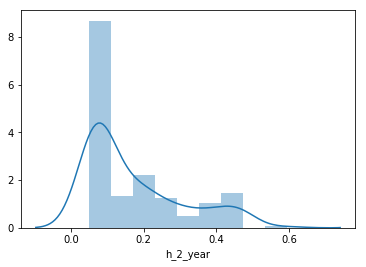

In [159]:
sns.distplot(df1['h_2_year'])
plt.show()

In [160]:
miss_df = pd.read_excel('data/test_data2.xlsx')

In [161]:
miss_df.shape

(50, 56)

In [162]:
miss_df.head()

,period,Other_ID1,Surname,Forename,query_run_date,valid_coefficients_date,referral_status,Ethnicitycleaned,Eth_co_ef,valid_ethnicity_recorded,...,tm_team,tm_email_address,Practice_Code,Practice_name,gp_start,gp_status,GP_recorded_date,CCG,telephone,email_address
0,T1,60-06-82,O'Farrell,Dean,2018-06-04,2018-09-27,Accepted,British (A),0.000000,2018-09-27 11:59:09.943,...,NaN,NaN,G85647,THE EXCHANGE SURGERY At,2018-05-20,active,2018-05-20 18:55:23.510,NHS LAMBETH CCG,020 30494888,Lamccg.exchangesurgeryreception@nhs.net
1,T1,60-16-91,Johnson,Andrew,2018-07-30,2018-09-21,Accepted,British (A),0.000000,2018-09-21 12:35:56.647,...,Croydon CMHT (Older Adults),Viola.Fahmy@slam.nhs.uk,G85096,T Ramanan,2018-06-05,active,2018-06-05 15:21:18.997,NHS LAMBETH CCG,020 86797536,g85096.docman@nhs.net
2,T1,58-49-64,Alexander,Latoya,2019-04-22,2019-04-17,Discharged,British (A),0.000000,2017-09-27 00:04:36.463,...,Leo Community Service,eduardo.iacoponi@slam.nhs.uk,Y03063,JV Patel,2018-11-26,ended,2018-11-26 08:42:32.403,NHS LAMBETH CCG,020 72749252,lamccg.pavilionpractice-ehs@nhs.net
3,T1,61-08-87,Ossoble,Mohammed,2018-11-05,2018-11-03,Accepted,African (N),1.037915,NaT,...,Leo Community Service,Lucy.Oates@slam.nhs.uk,G85096,THE VALE SURGERY At,2018-10-14,active,2018-10-14 09:27:34.257,NHS LAMBETH CCG,020 86797536,g85096.docman@nhs.net
4,T1,61-10-95,Marszal,Arkadiusz,2019-01-28,2019-01-28,Accepted,Any other white background (C),0.000000,2019-01-28 09:39:57.377,...,ADD-Lambeth Criminal Justice,Ed.Moses@slam.nhs.uk,Y03063,J Blackwell,2019-01-25,active,2019-01-25 11:31:24.587,NHS LAMBETH CCG,020 72749252,lamccg.pavilionpractice-ehs@nhs.net


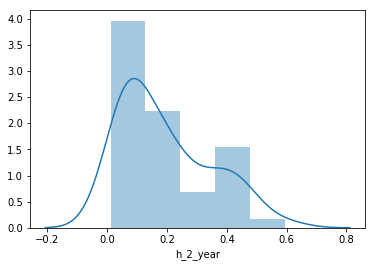

In [163]:
sns.distplot(miss_df['h_2_year'])
plt.show()

|ICD10_ID|Patient_ID|Invalid_Flag_ID|Diagnosis_Date|Primary_Diag|Secondary_Diag_1|Create_Dttm|User_Updated|Updated_Dttm|
|--------|----------|---------------|--------------|------------|----------------|-----------|------------|------------|
|840017|158601|0|2018-04-24 00:00:00|F23.9 - Acute and transient psychotic disorder, unspecified|F12.7 - Men & beh dis due cannabis; resid & late-onset psychot dis|2018-04-24 09:58:10|TSivathasan@slam.nhs.uk|2018-04-24 09:59:32|
|840019|158601|0|2018-04-24 00:00:00|F12.7 - Men & beh dis due cannabis; resid & late-onset psychot dis|F23.9 - Acute and transient psychotic disorder, unspecified|2018-04-24 09:59:32|MKoroma@slam.nhs.uk|2018-05-10 17:41:19|


In [164]:
set(miss_df['Other_ID1']) - set(df1['patient_other_id1'])

set()

In [165]:
# (set(df1['patient_other_id1']) - set(miss_df['Other_ID1']))

In [166]:
common_ids = set(miss_df['Other_ID1']).intersection(set(df1['patient_other_id1']))

In [167]:
len(set(miss_df['Other_ID1']).intersection(set(test_df['Other_ID1'])))

1

In [168]:
len(common_ids)

50

In [169]:
mis_count = 0
for id in common_ids:
    orig = miss_df[miss_df['Other_ID1'] == id]['PI'].values[0]
    cog = df1[df1['patient_other_id1'] == id]['PI'].values[0]
    if abs(orig - cog) > 0.00001:
        mis_count += 1
        print(str(id) + ' is different on PI values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = miss_df[miss_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df1[df1['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.00001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

60-02-64 is different on PI values: 0.5606118   0.1525082
	eth_coeff is different:  0.4081036   0.0
61-09-77 is different on PI values: -1.3828421   0.3281776999999999
	diagnosis_group_coeff is different:  -1.886428   -0.1754082
59-43-54 is different on PI values: -1.196455   0.17593079999999997
	diagnosis_group_coeff is different:  -1.547794   -0.1754082
3


### 60-02-64 Patient information updated after risk calculation

|Patient_ID|Other_ID1|Ethnicity_ID|Updated_Dttm|
|----------|---------|------------|------------|
|475107|60-02-64|24|2019-01-21 11:51:56|

### 59-43-54 invalid diagnosis

|ICD10_ID|Patient_ID|Invalid_Flag_ID|Diagnosis_Date|Primary_Diag|Create_Dttm|User_Updated|Updated_Dttm|
|--------|----------|---------------|--------------|------------|-----------|------------|------------|
|874399|469193|0|2018-11-02 00:00:00|F34.0 - Cyclothymia|2018-11-02 16:57:54|GHutchinson@slam.nhs.uk|2018-11-02 16:57:54|
|866664|469193|1|2018-09-19 00:00:00|F60.3 - Emotionally unstable personality disorder|2018-09-19 12:26:31|GHutchinson@slam.nhs.uk|2018-11-02 16:57:34|

### 61-09-77 invalid diagnosis

|ICD10_ID|Patient_ID|Invalid_Flag_ID|Diagnosis_Date|Primary_Diag|Create_Dttm|User_Updated|Updated_Dttm|
|--------|----------|---------------|--------------|------------|-----------|------------|------------|
|893265|485826|1|2019-02-14 00:00:00|F33.4 - Recurrent depressive disorder, currently in remission|2019-02-14 13:55:19|MKyratsous@slam.nhs.uk|2019-02-14 13:55:32|
|893266|485826|0|2019-02-14 00:00:00|F31.7 - Bipolar affective disorder, currently in remission|2019-02-14 13:56:01|MKyratsous@slam.nhs.uk|2019-02-14 13:56:01|
|871068|485826|0|2018-10-15 00:00:00|Z71.1 - Person with feared complaint in whom no diagnosis is made|2018-10-16 01:01:29|MKyratsous@slam.nhs.uk|2019-02-14 13:55:19|

In [124]:
finalmissid = set(df1['patient_other_id1']) - set(miss_df['Other_ID1']) - set(test_df['Other_ID1'])

In [125]:
finalmiss = df1[df1['patient_other_id1'].isin(list(finalmissid))]

In [126]:
finalmiss.to_csv('data/miss.csv', index=False)

In [127]:
finalmiss.shape

(6, 70)

In [128]:
finalmiss['patient_id']

1941    165901
2350    471862
2878    478969
3312    467202
3868    498062
4096    498669
Name: patient_id, dtype: object

## Patient 467202 has an updated GP on April 25th 2019 after diagnosis at June 12th 2018

## Patient 471862 has an updated diagnosis on June 27th 2018, and this diagnosis is recorded on April 9th 2018

## Patient 478969 has an updaetd demongraphic infor on June 4th 2019 and updated GP on October 19th 2018, after diagnosis on July 9th 2018

## Patient 498062 has an updated demographic info on June 6th 2019 and updated GP on May 28th 2019, after diagnosis on March 23rd 2019

## Patient 165901 has updated demographic and gp info on June 26 2019 after diagnosis on July 5 2018

## Patient 498669 has updated GP info on June 19 2019 after diagnosis on April 4 2019. 

In [72]:
testdf = finalmiss[finalmiss['patient_updated_dttm'] < finalmiss['diagnosis_updated_dttm']]

In [73]:
testdf.shape

(1, 49)

In [74]:
firstmatch = df1[df1['patient_other_id1'].isin(list(set(test_df['Other_ID1'])))]

In [75]:
secondmatch = df1[df1['patient_other_id1'].isin(list(set(miss_df['Other_ID1'])))]

In [76]:
firstmatch.shape

(117, 49)

In [77]:
secondmatch.shape

(50, 49)

In [78]:
len(set(firstmatch['practice_code']))

81

In [79]:
len(set(secondmatch['practice_code']))

41

In [80]:
# len(set(finalmiss['practice_code']))

In [82]:
match = set(firstmatch['patient_other_id1']).union(set(secondmatch['patient_other_id1']))
print(len(match))
print(len(set(finalmiss['patient_other_id1'])))
print(match.intersection(set(finalmiss['patient_other_id1'])))

166
4
set()


In [210]:
set(firstmatch['practice_code']).intersection(set(finalmiss['practice_code']))

{'G85041', 'G85136'}

In [211]:
set(secondmatch['practice_code']).intersection(set(finalmiss['practice_code']))

{'G85041', 'H83014', 'H83631'}